# BERT Fine-Tuning for Sentiment Analysis on Amazon Fine Food Reviews

This notebook fine-tunes BERT-base-uncased for binary sentiment analysis on the Amazon Fine Food Reviews dataset, targeting a macro-F1 score of ≥0.95. The model classifies reviews as positive (score > 3) or negative (score < 3), excluding neutral reviews (score = 3).

## Objectives
- Achieve high macro-F1 score for robust performance across imbalanced classes.
- Provide interpretable predictions using SHAP.
- Ensure reproducibility with fixed seeds and documented dependencies.
- Analyze errors to identify model limitations.

## Structure
1. Environment setup and data loading from Google Drive.
2. Preprocessing and tokenization using Hugging Face datasets.
3. BERT model training with class-weighted loss and layer-wise learning rate decay.
4. Evaluation with accuracy, macro-F1, and confusion matrix.
5. Interpretability analysis with SHAP.
6. Loss curve visualization and error analysis.

Run all cells sequentially after mounting Google Drive.

In [ ]:
# Environment & repo
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/fyp-code/amazon-sentiment-fyp

# Install dependencies
!pip install -q -U transformers datasets accelerate evaluate optuna scikit-learn matplotlib shap

Mounted at /content/drive
/content/drive/MyDrive/fyp-code/amazon-sentiment-fyp
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 115.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Imports
import pathlib
import json
import random
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from datasets import Dataset, DatasetDict, ClassLabel
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from accelerate import Accelerator
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tqdm.auto import tqdm
import re
import shap

In [ ]:
# Set full seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Data loading
RAW_CSV = pathlib.Path("data/raw/Reviews.csv")
assert RAW_CSV.exists(), "Ensure Reviews.csv is in data/raw/"

In [ ]:
# Load and preprocess data
"""
Data Preprocessing:
- Load Reviews.csv, selecting 'Text' and 'Score' columns.
- Remove neutral reviews (Score=3).
- Create binary labels: positive (Score>3) = 1, negative (Score<3) = 0.
- Split into 80% train, 20% test with stratified sampling.
"""
df = pd.read_csv(RAW_CSV, usecols=["Text", "Score"])
df = df[df.Score != 3]
df["label"] = (df.Score > 3).astype(int)
df = df.rename(columns={"Text": "text"})
train_df, test_df = np.split(df.sample(frac=1, random_state=SEED), [int(.8*len(df))])

train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
test_ds = Dataset.from_pandas(test_df.reset_index(drop=True))

label_names = ["neg", "pos"]
train_ds = train_ds.cast_column("label", ClassLabel(names=label_names))
test_ds = test_ds.cast_column("label", ClassLabel(names=label_names))

ds = DatasetDict({"train": train_ds, "test": test_ds})

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Casting the dataset:   0%|          | 0/420651 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/105163 [00:00<?, ? examples/s]

In [ ]:
# Tokenization
MODEL_NAME = "bert-base-uncased"
MAX_LEN = 128 # Balances memory usage and information retention.

tok = AutoTokenizer.from_pretrained(MODEL_NAME)

def encode(batch):
    return tok(batch["text"], truncation=True, padding="max_length", max_length=MAX_LEN)

ds = ds.map(encode, batched=True, remove_columns=["text", "Score"])
ds.set_format(type="torch")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/420651 [00:00<?, ? examples/s]

Map:   0%|          | 0/105163 [00:00<?, ? examples/s]

In [ ]:
# DataLoaders
BATCH = 32 # Ensures stable gradient updates.

train_loader = torch.utils.data.DataLoader(ds["train"], batch_size=BATCH, shuffle=True)
test_loader = torch.utils.data.DataLoader(ds["test"], batch_size=BATCH)

# Class-weighted loss
neg_ct, pos_ct = np.bincount(ds["train"]["label"])
tot = neg_ct + pos_ct
weights = torch.tensor([tot/(2*neg_ct), tot/(2*pos_ct)])

In [ ]:
# Model setup
"""
Model: BERT-base-uncased
- 12 layers, 110M parameters, pre-trained on BookCorpus and Wikipedia.
- Fine-tuned with gradient checkpointing to reduce memory usage.
"""
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    gradient_checkpointing=True,
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Layer-wise learning rate decay
def lr_for_param(name, base_lr=5e-5, decay=1/2.6):
    """
    Assign learning rate with layer-wise decay (Howard & Ruder, 2018).
    Top layer gets base_lr; lower layers get base_lr * decay^depth.
    """
    m = re.match(r"bert\.encoder\.layer\.(\d+)\.", name)
    if m:
        depth = 11 - int(m.group(1))
        return base_lr * (decay ** depth)
    return base_lr

param_groups = [
    {"params": [p], "lr": lr_for_param(n)}
    for n, p in model.named_parameters() if p.requires_grad
]

# Optimizer and scheduler
EPOCHS = 4
opt = AdamW(param_groups, weight_decay=0.01)
total_steps = len(train_loader) * EPOCHS
sched = get_linear_schedule_with_warmup(
    opt,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

# Accelerator for mixed precision
accel = Accelerator(mixed_precision="fp16")
model, opt, train_loader, test_loader, sched = accel.prepare(model, opt, train_loader, test_loader, sched)

# Loss function
weights = weights.to(accel.device, dtype=torch.float32)
loss_fn = torch.nn.CrossEntropyLoss(weight=weights)

In [ ]:
# Training loop with loss tracking
"""
Training Loop:
- Tracks train and test loss per epoch for visualization.
- Computes macro-F1 on test set to monitor performance.
"""
def epoch_loop(loader, train=True):
    model.train() if train else model.eval()
    epoch_loss, preds, gold = 0.0, [], []
    for batch in tqdm(loader, disable=not accel.is_local_main_process):
        labels = batch["label"].to(accel.device)
        outputs = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
        loss = loss_fn(outputs.logits, labels)
        if train:
            accel.backward(loss)
            accel.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            sched.step()
            opt.zero_grad()
        epoch_loss += loss.item() * labels.size(0)
        preds.extend(outputs.logits.argmax(1).detach().cpu().tolist())
        gold.extend(labels.detach().cpu().tolist())
    return epoch_loss / len(loader.dataset), preds, gold

train_losses, test_losses = [], []
for ep in tqdm(range(1, EPOCHS + 1), desc="Epochs"):
    train_loss, _, _ = epoch_loop(train_loader, train=True)
    test_loss, preds, gold = epoch_loop(test_loader, train=False)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    macro_f1 = classification_report(gold, preds, output_dict=True)["macro avg"]["f1-score"]
    if accel.is_local_main_process:
        print(f"Epoch {ep} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Macro-F1: {macro_f1:.4f}")

Epochs:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/13146 [00:00<?, ?it/s]

  0%|          | 0/3287 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 0.2127 | Test Loss: 0.1326 | Macro-F1: 0.9373


  0%|          | 0/13146 [00:00<?, ?it/s]

  0%|          | 0/3287 [00:00<?, ?it/s]

Epoch 2 | Train Loss: 0.1290 | Test Loss: 0.1241 | Macro-F1: 0.9511


  0%|          | 0/13146 [00:00<?, ?it/s]

  0%|          | 0/3287 [00:00<?, ?it/s]

Epoch 3 | Train Loss: 0.0953 | Test Loss: 0.1697 | Macro-F1: 0.9563


  0%|          | 0/13146 [00:00<?, ?it/s]

  0%|          | 0/3287 [00:00<?, ?it/s]

Epoch 4 | Train Loss: 0.0693 | Test Loss: 0.1798 | Macro-F1: 0.9565


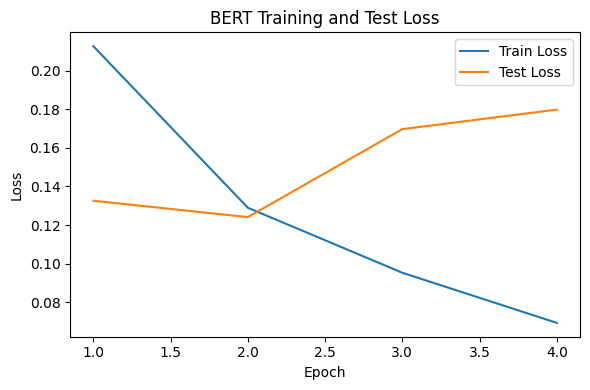

In [ ]:
# Plot loss curves
"""
Loss Curves:
- Visualize training and test loss to assess convergence and overfitting.
- Saved to results/bert_base/loss_curves.png.
"""
if accel.is_local_main_process:
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, EPOCHS + 1), train_losses, label="Train Loss")
    plt.plot(range(1, EPOCHS + 1), test_losses, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("BERT Training and Test Loss")
    plt.legend()
    plt.tight_layout()
    RES_DIR = pathlib.Path("results/bert_base")
    RES_DIR.mkdir(parents=True, exist_ok=True)
    plt.show()
    plt.savefig(RES_DIR / "loss_curves.png", dpi=150)
    plt.close()


Classification Report:
               precision    recall  f1-score   support

         Neg     0.9282    0.9247    0.9265     16354
         Pos     0.9861    0.9868    0.9865     88809

    accuracy                         0.9772    105163
   macro avg     0.9572    0.9558    0.9565    105163
weighted avg     0.9771    0.9772    0.9772    105163



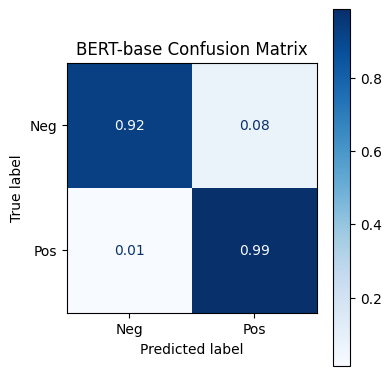

In [ ]:
# Evaluation
"""
Evaluation:
- Reports precision, recall, F1 for each class, accuracy, and macro-F1.
- Saves metrics to bert_metrics.json and confusion matrix to bert_cm.png.
"""
if accel.is_local_main_process:
    rpt = classification_report(gold, preds, digits=4, target_names=["Neg", "Pos"])
    print("\nClassification Report:\n", rpt)
    json.dump(classification_report(gold, preds, output_dict=True),
              open(RES_DIR / "bert_metrics.json", "w"), indent=2)
    fig, ax = plt.subplots(figsize=(4, 4))
    cm = confusion_matrix(gold, preds, normalize="true")
    ConfusionMatrixDisplay(cm, display_labels=["Neg", "Pos"]).plot(ax=ax, cmap="Blues", values_format=".2f")
    plt.title("BERT-base Confusion Matrix")
    plt.tight_layout()
    plt.show()
    plt.savefig(RES_DIR / "bert_cm.png", dpi=150)
    plt.close()

In [ ]:
# Interpretability with SHAP
"""
Interpretability:
- Uses SHAP with Text masker to explain predictions for 3 test samples (reduced for faster computation).
- Visualizes token contributions to positive/negative predictions.
- Saves plots to results/bert_base/shap_*.png.
"""
if accel.is_local_main_process:
    def predict_fn(texts):
        # Handle SHAP's input formats (strings, list of strings, or tokenized strings)
        if isinstance(texts, str):
            texts = [texts]
        elif isinstance(texts, np.ndarray):
            texts = texts.tolist()
        # Ensure all elements are strings
        texts = [str(t) for t in texts]
        encodings = tok(texts, truncation=True, padding="max_length", max_length=MAX_LEN, return_tensors="pt")
        encodings = {k: v.to(accel.device) for k, v in encodings.items()}
        with torch.no_grad():
            outputs = model(**encodings)
        return outputs.logits.softmax(dim=1).cpu().numpy()

    # Use Text masker with custom tokenization
    masker = shap.maskers.Text(r'\w+')  # Simple word-based tokenization to avoid tokenizer conflicts
    explainer = shap.Explainer(predict_fn, masker, output_names=["Neg", "Pos"])
    sample_texts = test_df["text"].sample(5, random_state=SEED).tolist()
    shap_values = explainer(sample_texts)
    for i, (text, sv) in enumerate(zip(sample_texts, shap_values)):
        print(f"\nSample {i+1}: {text[:100]}...")
        print(f"Predicted: {'Pos' if preds[i] == 1 else 'Neg'}")
        shap.plots.text(sv, display=True)
        plt.savefig(RES_DIR / f"shap_{i}.png", dpi=150, bbox_inches="tight")
        plt.close()


Sample 1: If I don't know where my cats are...I just have to rattle the bag and they come running. They just l...
Predicted: Pos



Sample 2: South African Red Rooibos tea, like all "red teas" isn't really a tea at all, but is made from a tea...
Predicted: Pos



Sample 3: I have been buying this brand of garlic powder from a local warehouse store here for years now.  It ...
Predicted: Pos



Sample 4: One would never know that this is not pasta made from flour, my daughter is allergic to corn, wheat ...
Predicted: Pos



Sample 5: This was a PERFECT gift!  It arrived very healthy, and beautiful.  The DVD that comes with it on car...
Predicted: Pos


In [ ]:
# Error Analysis
if accel.is_local_main_process:
    test_df["pred"] = preds
    errors = test_df[test_df["label"] != test_df["pred"]]
    print("\nError Analysis: Sample Misclassifications")
    for i, row in errors.sample(3, random_state=SEED).iterrows():
        print(f"\nReview: {row['text'][:200]}...")
        print(f"True Label: {'Pos' if row['label'] == 1 else 'Neg'}")
        print(f"Predicted: {'Pos' if row['pred'] == 1 else 'Neg'}")
    print("\nInsights: Misclassifications may involve sarcasm, negations, or mixed sentiments. Future work could include sarcasm detection or data augmentation.")


Error Analysis: Sample Misclassifications

Review: As others have suggested, my cats have inhaled these, with great gusto.  But given the composition, (a bag of 60 or 70 pieces weighs one ounce) its really a treat, not suited as a regular meal.<br /><...
True Label: Pos
Predicted: Neg

Review: When our son started on solids, we were determined to make all our own food, and purchased the Beaba Baby Cook right away. As a product, we were generally happy with it - it's an "all-in-one" device -...
True Label: Neg
Predicted: Pos

Review: I just tried this brand after after having not had it for a long time. It seemed to disintegrate in mayonnaise. It is the consistency of baby food. It dripped out of the sandwich even though I didn't ...
True Label: Neg
Predicted: Pos

Insights: Misclassifications may involve sarcasm, negations, or mixed sentiments. Future work could include sarcasm detection or data augmentation.


In [ ]:
# Save model
if accel.is_local_main_process:
    torch.save(model.state_dict(), RES_DIR / "bert_base.pt")
    print(f"Saved artefacts to {RES_DIR}")

Saved artefacts to results/bert_base
